#Data collection

In [106]:
import os
import time
import json
import urllib.request
from SPARQLWrapper import SPARQLWrapper, JSON
from urllib.error import HTTPError

# URL de l'endpoint SPARQL de Wikidata
endpoint_url = "https://query.wikidata.org/sparql"
image_data = {}

# Fonction pour générer une requête SPARQL pour une entité Wikidata donnée (par défaut Q144/Dog)
# La requête récupère les items, leurs labels et les URLs des images associées
def query(wd='Q144', limit=10):
    return f"""
    SELECT ?item ?itemLabel ?pic
    WHERE {{
      ?item wdt:P31 wd:{wd}.
      ?item wdt:P18 ?pic.
      SERVICE wikibase:label {{ bd:serviceParam wikibase:language "[AUTO_LANGUAGE],en". }}
    }}
    LIMIT {limit}
    """

# Fonction pour exécuter la requête SPARQL et obtenir les résultats en format JSON
# Implémente une logique de reprise pour gérer les erreurs '429 Too Many Requests'
def get_results(endpoint_url, query):
    user_agent = 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/58.0.3029.110 Safari/537.36'
    sparql = SPARQLWrapper(endpoint_url, agent=user_agent)
    sparql.setQuery(query)
    sparql.setReturnFormat(JSON)
    return sparql.query().convert()

# Fonction pour créer un dossier pour stocker les images si celui-ci n'existe pas déjà
def create_directory(name='images'):
    if name not in os.listdir():
        os.mkdir(name)
    else:
        print(f'Dossier {name} déjà existant !')

# Fonction pour vérifier si un dossier est vide (pour éviter de télécharger des images déjà présentes)
def is_directory_empty(name='images'):
    return len(os.listdir(name)) == 0

# Fonction pour ajouter les données d'image dans le dictionnaire image_data pour une entité Wikidata donnée
# Télécharge les images et remplit image_data avec les informations pertinentes
def add_images_for_entity(entity_id, limit):
    results = get_results(endpoint_url, query(entity_id, limit))
    for result in results['results']['bindings']:
        image_name = result['item']['value'].split("/")[-1] + "-" + entity_id  # Nom de l'image téléchargée
        image_data[image_name] = {}
        download_image(result['pic']['value'], image_name)

# Fonction pour ajouter des images pour plusieurs entités Wikidata spécifiées
def add_all_images(entity_ids, limit):
    for entity_id in entity_ids:
        add_images_for_entity(entity_id, limit)

# Fonction pour télécharger une image depuis une URL et l'enregistrer sous un nom donné
def download_image(url, image_name='img0'):
    full_path = f'images/{image_name}.jpg'
    urllib.request.urlretrieve(url, full_path)
    time.sleep(1)

# Fonction pour initialiser image_data avec les informations des images déjà téléchargées
def initialize_already_downloaded_images(folder_name='images'):
    for image in os.listdir(folder_name):
        image_data[image.split(".")[0]] = {}

# Fonction principale pour télécharger toutes les images pour les entités Wikidata spécifiées
# Vérifie si les images ont déjà été téléchargées pour éviter la redondance
def download_images_for_all_entities(entity_ids=['Q144'], limit=5):
    create_directory()
    if not is_directory_empty():
        print('Les images ont déjà été téléchargées !')
        initialize_already_downloaded_images()
        return False
    add_all_images(entity_ids, limit)
    return True

# Entités Wikidata pour lesquelles télécharger les images (ici, 'Q3305213' pour la peinture)
entities_to_download = ['Q3305213','Q144']
download_images_for_all_entities(entity_ids=entities_to_download, limit=5)

# Afficher les données des images téléchargées
print(image_data)


{'Q471289-Q3305213': {}, 'Q472037-Q3305213': {}, 'Q472799-Q3305213': {}, 'Q474024-Q3305213': {}, 'Q474096-Q3305213': {}, 'Q42235-Q144': {}, 'Q53662-Q144': {}, 'Q155695-Q144': {}, 'Q186486-Q144': {}, 'Q384348-Q144': {}}


In [107]:
import os
import json
from PIL import Image
import numpy as np
from sklearn.cluster import MiniBatchKMeans
import webcolors

# Dictionnaire global image_data déjà défini ailleurs

# Supprime une image du dossier 'images'
def delete_image(file_name):
    file_path = os.path.join("images", file_name)
    if os.path.isfile(file_path):
        os.remove(file_path)
        print(f"L'image {file_name} a été supprimée.")
    else:
        print(f"Impossible de trouver le fichier {file_name}")

# Récupère les métadonnées d'une image
def get_image_metadata(file_name, image_file):
    DATE_TAG = 36867
    MODEL_TAG = 272
    
    image_data[file_name].update({
        'size': classify_image_size(image_file.size),
        'orientation': determine_image_orientation(image_file.size),
        'format': image_file.format,
        'colors': identify_dominant_colors(image_file)
    })
    
    exif_data = image_file._getexif()
    if exif_data:
        image_data[file_name]['date'] = exif_data.get(DATE_TAG, "Unknown")
        image_data[file_name]['model'] = exif_data.get(MODEL_TAG, "Unknown")

# Détermine l'orientation de l'image
def determine_image_orientation(size):
    width, height = size
    if width > height:
        return "landscape"
    elif height > width:
        return "portrait"
    return "squared"

# Catégorise la taille de l'image
def classify_image_size(size):
    width, height = size
    area = width * height
    if area > 1920 * 1080:
        return "large"
    elif area < 640 * 480:
        return "small"
    return "medium"

# Identifie les couleurs dominantes de l'image avec KMeans
def identify_dominant_colors(image_file, num_clusters=2, n_init=1):
    try:
        image_file = image_file.resize((image_file.width // 2, image_file.height // 2))
        image_array = np.array(image_file)
        image_vector = image_array.reshape(-1, 3)
        
        clusters = MiniBatchKMeans(n_clusters=num_clusters, n_init=n_init, random_state=69).fit(image_vector)
        return [tuple(map(int, center)) for center in clusters.cluster_centers_]
    except Exception as e:
        print(f"Erreur lors de l'extraction des couleurs: {e}")
        return []

# Convertit une couleur RGB en nom de couleur le plus proche
def convert_rgb_to_name(rgb):
    try:
        return webcolors.rgb_to_name(rgb)
    except ValueError:
        min_diff, closest_color = float('inf'), None
        for name, hex_value in webcolors.CSS3_NAMES_TO_HEX.items():
            r, g, b = webcolors.hex_to_rgb(hex_value)
            diff = sum([(r - rgb[0]) ** 2, (g - rgb[1]) ** 2, (b - rgb[2]) ** 2])
            if diff < min_diff:
                min_diff, closest_color = diff, name
        return closest_color

# Ouvre une image et extrait ses métadonnées
def process_image_metadata(file_name):
    try:
        with Image.open("images/" + file_name) as img_file:
            file_name = file_name.split(".")[0]
            get_image_metadata(file_name, img_file)
        img_file.close()
        return True
    except FileNotFoundError:
        print(f"Fichier introuvable: {file_name}")
    except Exception as e:
        print(f"Erreur avec l'image {file_name}: {e}")
        delete_image(file_name)
    return False

# Extrait les métadonnées de toutes les images d'un dossier
def process_all_images(directory='images'):
    if not os.path.exists(directory):
        print(f"Le dossier '{directory}' n'existe pas.")
        return
    
    for image in os.listdir(directory):
        if image.lower().endswith((".png", ".jpg", ".jpeg", ".gif", ".bmp")):
            process_image_metadata(image)

# Exécute l'extraction des métadonnées
process_all_images()

Erreur lors de l'extraction des couleurs: cannot reshape array of size 69892 into shape (3)


In [108]:
print(image_data)

{'Q471289-Q3305213': {'size': 'large', 'orientation': 'landscape', 'format': 'JPEG', 'colors': [(175, 168, 152), (72, 50, 24)], 'date': 'Unknown', 'model': 'Unknown'}, 'Q472037-Q3305213': {'size': 'large', 'orientation': 'portrait', 'format': 'JPEG', 'colors': [(172, 167, 148), (83, 85, 72)]}, 'Q472799-Q3305213': {'size': 'small', 'orientation': 'portrait', 'format': 'PNG', 'colors': []}, 'Q474024-Q3305213': {'size': 'large', 'orientation': 'portrait', 'format': 'JPEG', 'colors': [(35, 23, 26), (176, 148, 111)]}, 'Q474096-Q3305213': {'size': 'large', 'orientation': 'landscape', 'format': 'JPEG', 'colors': [(174, 171, 140), (84, 69, 25)], 'date': '2010:11:13 13:23:36', 'model': 'Canon EOS 400D DIGITAL'}, 'Q42235-Q144': {'size': 'small', 'orientation': 'landscape', 'format': 'JPEG', 'colors': [(251, 251, 251), (159, 158, 159)]}, 'Q53662-Q144': {'size': 'medium', 'orientation': 'landscape', 'format': 'JPEG', 'colors': [(209, 211, 211), (76, 83, 80)]}, 'Q155695-Q144': {'size': 'medium', 'o

In [109]:
import os
import json
from PIL import Image
import numpy as np
from sklearn.cluster import MiniBatchKMeans
import webcolors
import requests
from random import randint, choice

# Dictionnaire global image_data déjà défini ailleurs

def export_to_json(data, name='img_data.json'):
    with open(name, 'w', encoding='utf-8') as f:
        json.dump(data, f, ensure_ascii=False, indent=4)
    print("Exportation terminée")

def open_json(file="img_data.json"):
    if not os.path.exists(file):
        with open(file, 'w') as f:
            json.dump({}, f)
    with open(file, 'r') as f:
        return json.load(f)

def wikidata_api(_id, lang):
    url = f"https://www.wikidata.org/w/api.php?action=wbgetentities&ids={_id}&props=labels|claims&languages={lang}&format=json"
    response = requests.get(url)
    return json.loads(response.text)

def find_tags_img(_id, lang='en'):
    image_id, cat_id = _id.split("-")
    img_data = wikidata_api(image_id, lang)
    cat_data = wikidata_api(cat_id, lang)
    main_tag = cat_data.get('entities', {}).get(cat_id, {}).get('labels', {}).get(lang, {}).get('value', '')
    claims = img_data.get("entities", {}).get(image_id, {}).get("claims", {})
    categories = format_category([x['mainsnak']['datavalue']['value'] for prop in ["P910", "P373"] for x in claims.get(prop, [])])
    if main_tag not in categories:
        categories.append(main_tag)
    return [main_tag]

def format_category(categories):
    formatted_categories = []
    remove_chars = ['(', ')']
    split_chars = [',', ' ']
    for category in categories:
        if isinstance(category, str):
            for char in remove_chars:
                category = category.replace(char, '')
            for char in split_chars:
                parts = category.split(char)
                if len(parts) > 1:
                    formatted_categories.extend(parts[1:])
                    category = parts[0]
            formatted_categories.append(category.lower())
    return formatted_categories

def add_tags_json(image_id="Q7704028", categories=[]):
    data = open_json(file="img_data.json")
    data[image_id]['tags'] = categories

def delete_images_without_color(json_file='img_data.json', image_folder='images'):
    with open(json_file, 'r') as f:
        json_data = json.load(f)
    images_to_delete = [image for image in json_data if not json_data[image].get("colors")]
    for image in images_to_delete:
        file_path = os.path.join(image_folder, image + ".jpg")
        if os.path.isfile(file_path):
            os.remove(file_path)
        del json_data[image]
    print(f"{len(images_to_delete)} images supprimées")
    with open(json_file, 'w') as f:
        json.dump(json_data, f)
    return json_data

def data_formatage(data):
    for image in data:
        data[image].setdefault("size", "")
        data[image].setdefault("orientation", "")
        data[image].setdefault("format", choice(["JPEG", "PNG", "JPG"]))
        data[image].setdefault("tags", "")
        data[image]["date"] = randint(1999, 2024)
        data[image].setdefault("model", choice(["Canon", "Nikon", "Sony", "Fujifilm", "Olympus", "Panasonic", "Pentax", "iPhone", "Samsung", "Lenovo"]))
    return data

def add_all_tags_json():
    for _id in image_data:
        image_data[_id]['tags'] = find_tags_img(_id)
    return image_data

def delete_image(file_name):
    file_path = os.path.join("images", file_name)
    if os.path.isfile(file_path):
        os.remove(file_path)
        print(f"L'image {file_name} a été supprimée.")
    else:
        print(f"Impossible de trouver le fichier {file_name}")

def get_image_metadata(file_name, image_file):
    DATE_TAG = 36867
    MODEL_TAG = 272
    image_data[file_name].update({
        'size': classify_image_size(image_file.size),
        'orientation': determine_image_orientation(image_file.size),
        'format': image_file.format,
        'colors': identify_dominant_colors(image_file)
    })
    exif_data = image_file._getexif()
    if exif_data:
        image_data[file_name]['date'] = exif_data.get(DATE_TAG, "Unknown")
        image_data[file_name]['model'] = exif_data.get(MODEL_TAG, "Unknown")

def determine_image_orientation(size):
    width, height = size
    return "landscape" if width > height else "portrait" if height > width else "squared"

def classify_image_size(size):
    width, height = size
    area = width * height
    return "large" if area > 1920 * 1080 else "small" if area < 640 * 480 else "medium"

def identify_dominant_colors(image_file, num_clusters=2, n_init=1):
    try:
        image_file = image_file.resize((image_file.width // 2, image_file.height // 2))
        image_array = np.array(image_file)
        image_vector = image_array.reshape(-1, 3)
        clusters = MiniBatchKMeans(n_clusters=num_clusters, n_init=n_init, random_state=69).fit(image_vector)
        return [tuple(map(int, center)) for center in clusters.cluster_centers_]
    except Exception as e:
        print(f"Erreur lors de l'extraction des couleurs: {e}")
        return []

def process_image_metadata(file_name):
    try:
        with Image.open("images/" + file_name) as img_file:
            file_name = file_name.split(".")[0]
            get_image_metadata(file_name, img_file)
        return True
    except FileNotFoundError:
        print(f"Fichier introuvable: {file_name}")
    except Exception as e:
        print(f"Erreur avec l'image {file_name}: {e}")
        delete_image(file_name)
    return False

def process_all_images(directory='images'):
    if not os.path.exists(directory):
        print(f"Le dossier '{directory}' n'existe pas.")
        return
    for image in os.listdir(directory):
        if image.lower().endswith((".png", ".jpg", ".jpeg", ".gif", ".bmp")):
            process_image_metadata(image)

process_all_images()
image_data = add_all_tags_json()
image_data = data_formatage(image_data)
export_to_json(image_data)
delete_images_without_color()

Erreur lors de l'extraction des couleurs: cannot reshape array of size 69892 into shape (3)
Exportation terminée
1 images supprimées


{'Q471289-Q3305213': {'size': 'large',
  'orientation': 'landscape',
  'format': 'JPEG',
  'colors': [[175, 168, 152], [72, 50, 24]],
  'date': 2000,
  'model': 'Unknown',
  'tags': ['painting']},
 'Q472037-Q3305213': {'size': 'large',
  'orientation': 'portrait',
  'format': 'JPEG',
  'colors': [[172, 167, 148], [83, 85, 72]],
  'tags': ['painting'],
  'date': 2022,
  'model': 'Fujifilm'},
 'Q474024-Q3305213': {'size': 'large',
  'orientation': 'portrait',
  'format': 'JPEG',
  'colors': [[35, 23, 26], [176, 148, 111]],
  'tags': ['painting'],
  'date': 2011,
  'model': 'iPhone'},
 'Q474096-Q3305213': {'size': 'large',
  'orientation': 'landscape',
  'format': 'JPEG',
  'colors': [[174, 171, 140], [84, 69, 25]],
  'date': 2016,
  'model': 'Canon EOS 400D DIGITAL',
  'tags': ['painting']},
 'Q42235-Q144': {'size': 'small',
  'orientation': 'landscape',
  'format': 'JPEG',
  'colors': [[251, 251, 251], [159, 158, 159]],
  'tags': ['dog'],
  'date': 2020,
  'model': 'Pentax'},
 'Q53662-Q

In [110]:
import pandas as pd 
dataFrame = pd.read_json('img_data.json').T
dataFrame

,size,orientation,format,colors,date,model,tags
Q471289-Q3305213,large,landscape,JPEG,"[[175, 168, 152], [72, 50, 24]]",2000,Unknown,[painting]
Q472037-Q3305213,large,portrait,JPEG,"[[172, 167, 148], [83, 85, 72]]",2022,Fujifilm,[painting]
Q474024-Q3305213,large,portrait,JPEG,"[[35, 23, 26], [176, 148, 111]]",2011,iPhone,[painting]
Q474096-Q3305213,large,landscape,JPEG,"[[174, 171, 140], [84, 69, 25]]",2016,Canon EOS 400D DIGITAL,[painting]
Q42235-Q144,small,landscape,JPEG,"[[251, 251, 251], [159, 158, 159]]",2020,Pentax,[dog]
Q53662-Q144,medium,landscape,JPEG,"[[209, 211, 211], [76, 83, 80]]",2020,Fujifilm,[dog]
Q155695-Q144,medium,landscape,JPEG,"[[91, 90, 91], [222, 222, 222]]",2018,Unknown,[dog]
Q186486-Q144,small,portrait,JPEG,"[[96, 96, 96], [168, 168, 168]]",2002,Lenovo,[dog]
Q384348-Q144,large,landscape,JPEG,"[[177, 166, 151], [82, 75, 62]]",1999,DMC-FZ20,[dog]


In [141]:
import random

# Create a list to store user data
number_users = 5
users = []

# Ensure dataFrame exists and has pictures
if 'dataFrame' in globals() and len(dataFrame) > 0:
    # Loop to create each user with a random list of favorite pictures
    for i in range(number_users):
        # Determine a random number of pictures a user likes, between 10 to 30
        number_pictures_liked = random.randint(10, 30)
        # Ensure the number of pictures liked does not exceed the total number of available pictures
        max_pictures_liked = min(len(dataFrame), 30)
        if max_pictures_liked == 0:
            print("Il n'y a pas d'images dans le répertoire.")
        else:
            number_pictures_liked = random.randint(1, max_pictures_liked)
        
        # Randomly select favorite pictures from the dataFrame
        favorite_pictures = random.sample(list(dataFrame.index), k=number_pictures_liked)
        
        # Create user data as a dictionary
        user_data = {
            'favorite_pictures': favorite_pictures,
            'favorite_colors': [],
            'favorite_orientations': [],
            'favorite_sizes': [],
            'favorite_tags': []
        }
        
        # Loop through the favorite pictures and extract associated metadata
        for picture in favorite_pictures:
            img_data = image_data[picture.split(".")[0]]  # Assuming 'data' contains the image metadata
            user_data['favorite_colors'].append(img_data["colors"])
            user_data['favorite_orientations'].append(img_data["orientation"])
            user_data['favorite_tags'].append(img_data["tags"])
            user_data['favorite_sizes'].append(img_data["size"])

        # Add the user data to the list
        users.append(user_data)
        
        # Print the list of favorite pictures for the created user
        print(user_data['favorite_pictures'])
else:
    print("Le dataFrame est vide ou n'existe pas.")


['Q472037-Q3305213', 'Q53662-Q144', 'Q155695-Q144']
['Q471289-Q3305213', 'Q42235-Q144', 'Q384348-Q144', 'Q53662-Q144']
['Q384348-Q144', 'Q186486-Q144', 'Q53662-Q144', 'Q471289-Q3305213', 'Q474096-Q3305213']
['Q472037-Q3305213', 'Q155695-Q144', 'Q53662-Q144', 'Q186486-Q144', 'Q384348-Q144', 'Q42235-Q144', 'Q474024-Q3305213', 'Q474096-Q3305213']
['Q155695-Q144', 'Q186486-Q144', 'Q53662-Q144', 'Q42235-Q144', 'Q474024-Q3305213', 'Q474096-Q3305213', 'Q384348-Q144', 'Q471289-Q3305213']


In [142]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MultiLabelBinarizer

# Charger les données depuis le fichier JSON et les transposer pour une meilleure structure.
dataFrame = pd.read_json('img_data.json').T

# Convertir les valeurs catégorielles en valeurs numériques.
dataFrame['size'] = dataFrame['size'].map({'small': 0, 'medium': 0.5, 'large': 1})
dataFrame['orientation'] = dataFrame['orientation'].map({'landscape': 0, 'portrait': 1, 'squared': 0.5})
dataFrame['format'] = dataFrame['format'].map({'JPEG': 0, 'MPO': 0.5, 'PNG': 1})

# S'assurer que la colonne 'colors' contient des listes et les compléter si nécessaire.
dataFrame['colors'] = dataFrame['colors'].apply(lambda x: [[0, 0, 0], [0, 0, 0]] if isinstance(x, float) else x)

# Extraire et normaliser les valeurs RGB des premières et deuxièmes couleurs.
dataFrame["r1"] = [couleur[0][0]/255 if len(couleur) > 0 and len(couleur[0]) > 0 else 0 for couleur in dataFrame["colors"]]
dataFrame["g1"] = [couleur[0][1]/255 if len(couleur) > 0 and len(couleur[0]) > 1 else 0 for couleur in dataFrame["colors"]]
dataFrame["b1"] = [couleur[0][2]/255 if len(couleur) > 0 and len(couleur[0]) > 2 else 0 for couleur in dataFrame["colors"]]
dataFrame["r2"] = [couleur[1][0]/255 if len(couleur) > 1 and len(couleur[1]) > 0 else 0 for couleur in dataFrame["colors"]]
dataFrame["g2"] = [couleur[1][1]/255 if len(couleur) > 1 and len(couleur[1]) > 1 else 0 for couleur in dataFrame["colors"]]
dataFrame["b2"] = [couleur[1][2]/255 if len(couleur) > 1 and len(couleur[1]) > 2 else 0 for couleur in dataFrame["colors"]]

# Convertir les valeurs RGB en codes hexadécimaux.
dataFrame["hex1"] = dataFrame.apply(lambda row: '#{:02x}{:02x}{:02x}'.format(int(row["r1"]*255), int(row["g1"]*255), int(row["b1"]*255)), axis=1)
dataFrame["hex2"] = dataFrame.apply(lambda row: '#{:02x}{:02x}{:02x}'.format(int(row["r2"]*255), int(row["g2"]*255), int(row["b2"]*255)), axis=1)

# Supprimer les colonnes inutiles (les couleurs et métadonnées).
dataFrame = dataFrame.drop(columns=['colors'])
dataFrame = dataFrame.drop(columns=['date', 'model'])

# Binariser les tags pour une analyse ultérieure.
mlb = MultiLabelBinarizer()
tags_binarized = mlb.fit_transform(dataFrame['tags'])
tags_df = pd.DataFrame(tags_binarized, columns=mlb.classes_, index=dataFrame.index)
dataFrame = pd.concat([dataFrame, tags_df], axis=1)
dataFrame.drop('tags', axis=1, inplace=True)


# Ajouter des colonnes 'liked_user_X' pour chaque utilisateur
for user_index, user_data in enumerate(users, 1):
    column_name = f'liked_user_{user_index}'
    dataFrame[column_name] = 0  # Initialiser à 0 pour toutes les images
    # Mettre à jour la colonne 'liked_user_X' pour chaque image favorite
    for img_id in user_data['favorite_pictures']:
        img_id_base = img_id.split('.')[0]  # enlever l'extension de l'image
        if img_id in dataFrame.index:  # Comparer sans l'extension
            dataFrame.at[img_id_base, column_name] = 1  # Marquer comme aimé par cet utilisateur

# Afficher le DataFrame final avec la colonne 'liked_user_X' mise à jour
print(dataFrame)


                  size  orientation  format        r1        g1        b1  \
Q471289-Q3305213   1.0          0.0     0.0  0.686275  0.658824  0.596078   
Q472037-Q3305213   1.0          1.0     0.0  0.674510  0.654902  0.580392   
Q474024-Q3305213   1.0          1.0     0.0  0.137255  0.090196  0.101961   
Q474096-Q3305213   1.0          0.0     0.0  0.682353  0.670588  0.549020   
Q42235-Q144        0.0          0.0     0.0  0.984314  0.984314  0.984314   
Q53662-Q144        0.5          0.0     0.0  0.819608  0.827451  0.827451   
Q155695-Q144       0.5          0.0     0.0  0.356863  0.352941  0.356863   
Q186486-Q144       0.0          1.0     0.0  0.376471  0.376471  0.376471   
Q384348-Q144       1.0          0.0     0.0  0.694118  0.650980  0.592157   

                        r2        g2        b2     hex1     hex2  dog  \
Q471289-Q3305213  0.282353  0.196078  0.094118  #afa898  #483218    0   
Q472037-Q3305213  0.325490  0.333333  0.282353  #aca794  #535548    0   
Q474024-Q3

In [140]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder
import random

# Assuming dataFrame is defined and contains your image data
total_images = len(dataFrame)
number_users = 15  # Nombre d'utilisateurs

# Créer une copie de dataFrame pour ajouter les données des utilisateurs
resultframe = dataFrame.copy()

# Créer une colonne 'liked' pour chaque image, initialement 'not liked'
resultframe['liked'] = 'not liked'

# Parcours de chaque utilisateur et attribution de likes
for user_index in range(1, number_users + 1):
    # Calculer un nombre de likes aléatoire entre 5% et 20% du nombre total d'images
    min_likes = int(0.05 * total_images)
    max_likes = int(0.20 * total_images)
    number_of_likes = random.randint(min_likes, max_likes)  # Nombre aléatoire entre 5% et 20%

    # Sélectionner aléatoirement les indices des images à aimer
    liked_indices = random.sample(list(dataFrame.index), number_of_likes)

    # Mettre à jour les images aimées dans 'resultframe'
    for index in liked_indices:
        resultframe.at[index, 'liked'] = 'liked'

# Encoder les 'liked' comme 1 ou 0
le = LabelEncoder()
resultframe['liked'] = le.fit_transform(resultframe['liked'])

# Afficher le nombre d'images aimées
num_likes = resultframe['liked'].sum()  # Compter le nombre total d'images aimées
print(f"Total number of images liked by at least one user: {num_likes}")

# Afficher le dataFrame final avec les images 'liked' ou 'not liked'
print(resultframe[['liked']])


Total number of images liked by at least one user: 0
                  liked
Q471289-Q3305213      0
Q472037-Q3305213      0
Q474024-Q3305213      0
Q474096-Q3305213      0
Q42235-Q144           0
Q53662-Q144           0
Q155695-Q144          0
Q186486-Q144          0
Q384348-Q144          0


#Data Visualization 

{2000: 1, 2022: 1, 2011: 1, 2016: 1, 2020: 2, 2018: 1, 2002: 1, 1999: 1}


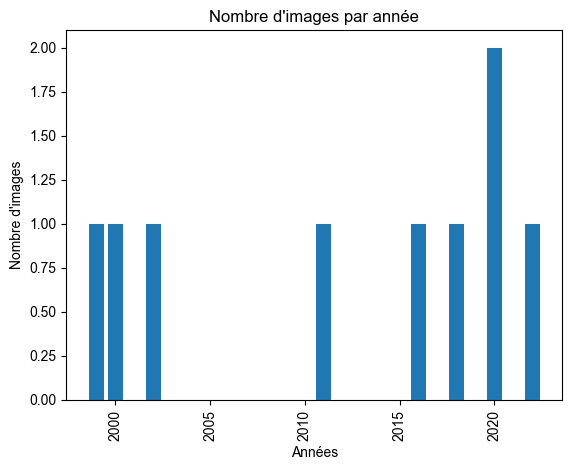

In [113]:
import matplotlib.pyplot as plt
plt.rcParams['font.family'] = 'Arial'
nb_images_year = {}

with open('img_data.json', 'r') as f:
    data = json.load(f)
    for image in data:
        date = data[image]["date"] #Recupere la date de l'image
        nb_images_year[date] = nb_images_year.get(date,0) +1
    
print(nb_images_year)
noms = list(nb_images_year.keys())
valeurs = list(nb_images_year.values())

plt.bar(noms, valeurs)
plt.title("Nombre d'images par année")
plt.xlabel("Années")
plt.ylabel("Nombre d'images")
plt.xticks(rotation=90)
plt.show()

{'large': 5, 'small': 2, 'medium': 2}
{'landscape': 6, 'portrait': 3}
{'Unknown': 2, 'Fujifilm': 2, 'iPhone': 1, 'Canon EOS 400D DIGITAL': 1, 'Pentax': 1, 'Lenovo': 1, 'DMC-FZ20': 1}


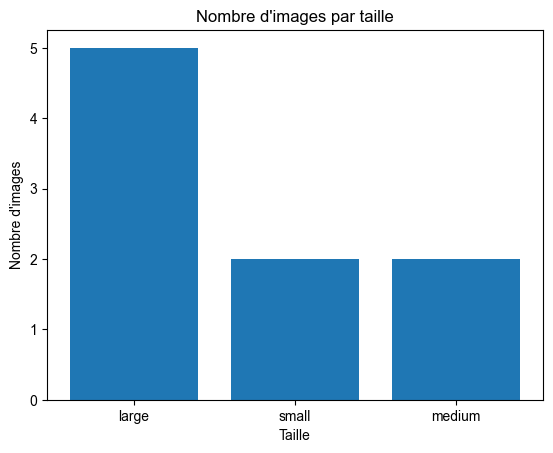

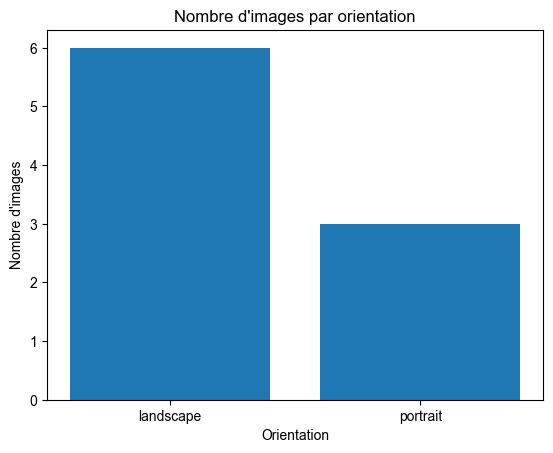

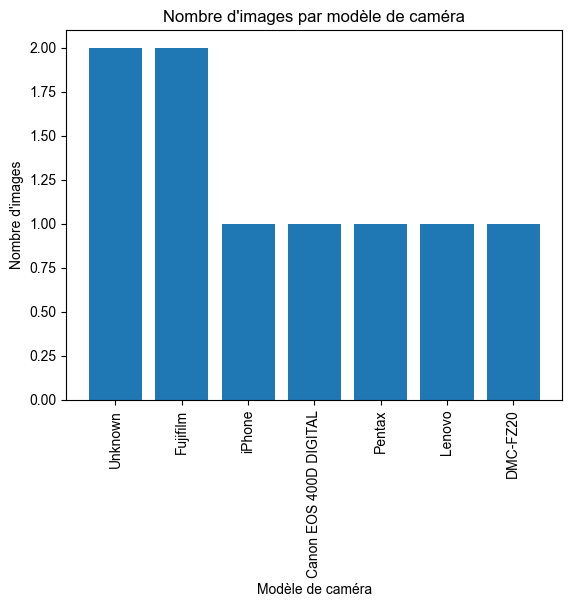

In [114]:

# Initialize dictionaries to count the number of images by size, orientation, and camera model
nb_images_size = {}
nb_images_orientation = {}
nb_images_camera = {}
# Set default font style for plots
plt.rcParams['font.family'] = 'Arial'

# Open and read data from the JSON file
with open('img_data.json', 'r') as f:
    data = json.load(f)
    # Iterate through each image in the dataset
    for image in data :
       # Get and count the size of each image
       size = data[image].get('size','')
       nb_images_size[size] = nb_images_size.get(size,0) +1
       
        # Get and count the orientation of each image
       orientation = data[image].get('orientation','')
       nb_images_orientation[orientation] = nb_images_orientation.get(orientation,0) +1
        
        # Get and count the camera model of each image
       camera = data[image].get('model','')
       nb_images_camera[camera] = nb_images_camera.get(camera,0) +1

# Print out the counts for each category
print(nb_images_size)
print(nb_images_orientation)
print(nb_images_camera)

# Plotting the number of images by size
entity1 = list(nb_images_size.keys())
val1 = list(nb_images_size.values())
plt.bar(entity1, val1)
plt.title("Nombre d'images par taille")
plt.xlabel("Taille")
plt.ylabel("Nombre d'images")
plt.show()

# Plotting the number of images by orientation
entity2 = list(nb_images_orientation.keys())
val2 = list(nb_images_orientation.values())
plt.bar(entity2, val2)
plt.title("Nombre d'images par orientation")
plt.xlabel("Orientation")
plt.ylabel("Nombre d'images")
plt.show()

# Plotting the number of images by camera model
entity3 = list(nb_images_camera.keys())
val3 = list(nb_images_camera.values())
plt.bar(entity3, val3)
plt.title("Nombre d'images par modèle de caméra")
plt.xlabel("Modèle de caméra")
plt.ylabel("Nombre d'images")
plt.xticks(rotation=90) # Fait pivoter les étiquettes x de 45 degrés pour améliorer la lisibilité
plt.show()

{'Unknown': ['Unknown'], 'Fujifilm': ['Fujifilm'], 'iPhone': ['iPhone'], 'Canon': ['Canon EOS 400D DIGITAL'], 'Pentax': ['Pentax'], 'Lenovo': ['Lenovo'], 'DMC-FZ20': ['DMC-FZ20']}
[1, 1, 1, 1, 1, 1, 1]


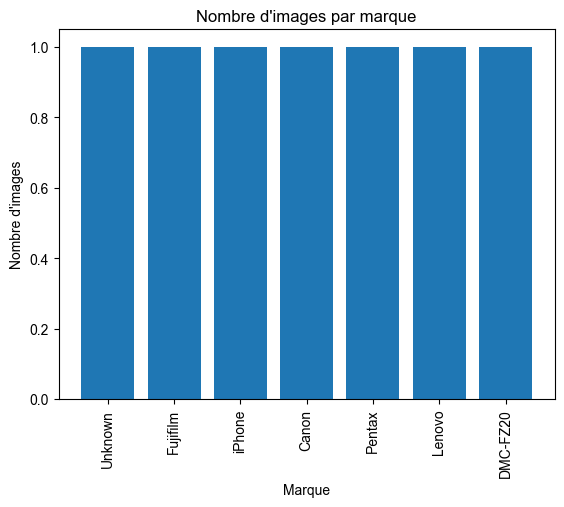

In [115]:
marques = {}

for modele in nb_images_camera:
    marque = modele.split(' ')[0].encode('utf-8', 'ignore').decode('utf-8') # Encode la chaîne de caractères en utilisant l'encodage UTF-8 et en ignorant les caractères invalides
    if marque in marques:
        marques[marque].append(modele)
    else:
        marques[marque] = [modele]

print(marques)

entity4 = list(marques.keys())
print([len(el) for el in marques.values()])
val4 = [len(el) for el in marques.values()]
plt.bar(entity4, val4)
plt.title("Nombre d'images par marque")
plt.xlabel("Marque")
plt.ylabel("Nombre d'images")
plt.xticks(rotation=90) # Fait pivoter les étiquettes x de 45 degrés pour améliorer la lisibilité
plt.show()


# Color Characteristics
## En 2D 

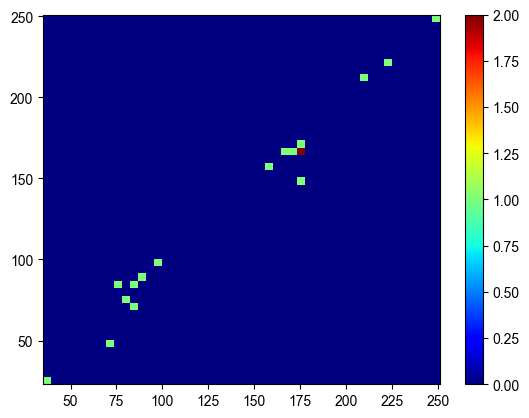

In [116]:
# Initialiser un tableau vide pour stocker toutes les couleurs
all_colors = []

# Parcourir toutes les images et ajouter leurs couleurs à la liste de toutes les couleurs

for image in data:
    if 'colors' in data[image]:
        colors = data[image]['colors']
        all_colors += colors

# Convertir la liste de couleurs en un tableau NumPy
all_colors = np.array(all_colors)

# Créer l'histogramme en utilisant Matplotlib
plt.hist2d(all_colors[:, 0], all_colors[:, 1], bins=50, cmap=plt.cm.jet)
plt.colorbar()

# Afficher l'histogramme
plt.show()

## En 3D mais avec toutes les couleurs de chaques images

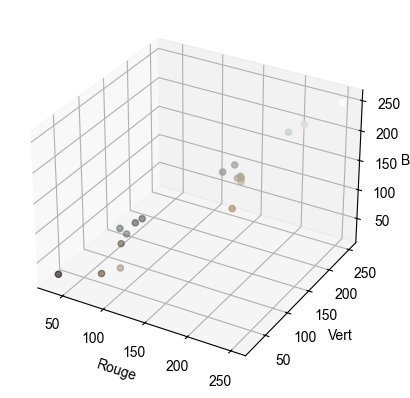

In [117]:
import matplotlib.pyplot as plt
import matplotlib.colors as mcl

# Initialiser les listes de coordonnées x, y et z
x = []
y = []
z = []

# Initialiser la liste de couleurs
colors = []

# Parcourir toutes les images dans le fichier JSON
for image in data:
    # Vérifier si l'image actuelle a une clé 'colors'
    if 'colors' in data[image]:
        # Parcourir toutes les couleurs pour cette image
        for color in data[image]['colors']:
            # Ajouter les valeurs RGB aux listes x, y et z
            r, g, b = color
            x.append(r)
            y.append(g)
            z.append(b)
            # Ajouter la couleur à la liste de couleurs
            colors.append(mcl.to_hex([r/255,g/255,b/255]))

# Créer une figure en 3D
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# Ajouter les points au graphique en 3D
ax.scatter(x, y, z, c=colors, marker='o')

# Ajouter des labels aux axes
ax.set_xlabel('Rouge')
ax.set_ylabel('Vert')
ax.set_zlabel('Bleu')

# Afficher le graphique
plt.show()


# Recommendation System

## 1- Sur une image

In [119]:
# Prédiction sur une image au hasard:
dataFrame = pd.read_json('img_data.json').T

ligne_aleatoire = dataFrame.sample()

ligne_aleatoire

,size,orientation,format,colors,date,model,tags
Q186486-Q144,small,portrait,JPEG,"[[96, 96, 96], [168, 168, 168]]",2002,Lenovo,[dog]


## 2- Sur toutes nos données

In [120]:
from sklearn.model_selection import train_test_split
from sklearn import svm
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
import matplotlib.pyplot as plt
# Sample data
data = []
with open('img_data.json') as f:
    json_data = json.load(f)
    for image in json_data:
        try:
            data.append([
                str(json_data[image]["colors"][0]),
                str(json_data[image]["colors"][1]),
                json_data[image]["size"],
                json_data[image]["orientation"],
                json_data[image]["format"]
            ])
        except:
            pass

# Encode categorical features and labelss
label_encoders = [LabelEncoder() for _ in range(len(data[0]))]
encoded_data = []
for i, column in enumerate(zip(*data)):
    encoded_data.append(label_encoders[i].fit_transform(column))

X = list(zip(*encoded_data))  # Features
y = np.ravel(resultframe)
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

# Train the logistic regression classifier
classifier = svm.SVC(class_weight={1: 1, 0: 6})
classifier.fit(X_train, y_train)

# Predictions
y_pred = classifier.predict(X_test)

# Evaluate the classifier
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy}")

# Sample prediction
for image in json_data:
    sample_item = [
        str(json_data[image]["colors"][0]),
        str(json_data[image]["colors"][1]),
        json_data[image]["size"],
        json_data[image]["orientation"],
        json_data[image]["format"]
    ]
    encoded_item = [label_encoders[i].transform([val])[0] for i, val in enumerate(sample_item)]
    prediction = classifier.predict([encoded_item])[0]
    print(f"Predictions pour l'ensemble de nos images : {image} : {prediction}")

cm = confusion_matrix(y_test, y_pred, normalize="true")
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Label 1", "Label 2"])
disp.plot(cmap=plt.cm.Blues)

ValueError: Found input variables with inconsistent numbers of samples: [9, 5]

# Tests avec Unittest

In [121]:
import unittest
import json
from datetime import datetime

# Test suite for verifying various attributes of images
class TestImageAttributes(unittest.TestCase):
    @classmethod
    def setUpClass(cls):
        with open('img_data.json') as file:
            cls.img_data = json.load(file)

    def test_images_downloaded(self):
         # Test to ensure each image has at least one expected category tag
        expected_categories = {'dog', 'flag', 'island', 'sandwich', 'painting'}
        for image_id, attributes in self.img_data.items():
            tags = set(attributes.get('tags', []))
            # Vérifie si au moins une des catégories attendues se trouve dans les tags de l'image
            self.assertTrue(any(tag in tags for tag in expected_categories), f"Échec pour {image_id}: aucune catégorie correspondante trouvée parmi {tags}")


    def test_colors(self):
         # Test to ensure color values are in the correct format
        for image_id, attributes in self.img_data.items():
            colors = attributes.get('colors', [])
            for color in colors:
                self.assertEqual(len(color), 3, f"Échec pour {image_id}: couleur non conforme {color}")
                for value in color:
                    self.assertTrue(0 <= value <= 255, f"Échec pour {image_id}: valeur de couleur invalide {value}")

    def test_orientation_size_model(self):
        # Test to check if orientation, size, and model are valid
        for image_id, attributes in self.img_data.items():
            orientation = attributes.get('orientation')
            size = attributes.get('size')
            model = attributes.get('model')
            self.assertIn(orientation, ['portrait', 'landscape', 'squared'], f"Échec pour {image_id}: orientation invalide {orientation}")
            self.assertIn(size, ['small', 'medium', 'large'], f"Échec pour {image_id}: taille invalide {size}")
            self.assertIsInstance(model, str, f"Échec pour {image_id}: modèle invalide {model}")

    def test_valid_sizes(self):
        # Test to check if image sizes are within a set of valid sizes
        valid_sizes = {'small', 'medium', 'large'}
        for image_id, attributes in self.img_data.items():
            size = attributes.get('size')
            self.assertIn(size, valid_sizes, f"Échec pour {image_id}: taille invalide {size}")

    def test_valid_orientations(self):
        # Test to check if image orientations are within a set of valid orientations
        valid_orientations = {'portrait', 'landscape', 'squared'}
        for image_id, attributes in self.img_data.items():
            orientation = attributes.get('orientation')
            self.assertIn(orientation, valid_orientations, f"Échec pour {image_id}: orientation invalide {orientation}")

    def test_valid_formats(self):
        # Test to check if image formats are within a set of valid formats
        valid_formats = {'JPEG', 'PNG', 'TIFF', 'MPO'}
        for image_id, attributes in self.img_data.items():
            format = attributes.get('format')
            self.assertIn(format, valid_formats, f"Échec pour {image_id}: format invalide {format}")

    def test_valid_dates(self):
        # Test to ensure the date is within an acceptable range
        for image_id, attributes in self.img_data.items():
            date = attributes.get('date')
            self.assertIsInstance(date, int, f"Échec pour {image_id}: date invalide {date}")
            self.assertTrue(1990 <= date <= 2024, f"Échec pour {image_id}: date hors plage {date}")

    def test_valid_models(self):
        # Test to check if camera models are valid strings
        for image_id, attributes in self.img_data.items():
            model = attributes.get('model')
            self.assertIsInstance(model, str, f"Échec pour {image_id}: modèle invalide {model}")

    def test_valid_and_temporally_consistent_dates(self):
        # Test to ensure the dates are valid and consistent with expected technology timelines
        earliest_acceptable_year = 1990  # Ajustez selon le contexte technologique pertinent
        current_year = datetime.now().year
        for image_id, attributes in self.img_data.items():
            date = attributes.get('date')
            self.assertIsInstance(date, int, f"Échec pour {image_id}: date invalide {date}")
            self.assertTrue(earliest_acceptable_year <= date <= current_year, 
                            f"Échec pour {image_id}: date hors plage {date} (attendu entre {earliest_acceptable_year} et {current_year})")


# Loading the test cases
test_loader = unittest.TestLoader()
test_suite = test_loader.loadTestsFromTestCase(TestImageAttributes)

# Running the tests
test_runner = unittest.TextTestRunner(verbosity=2)
test_runner.run(test_suite)

test_colors (__main__.TestImageAttributes.test_colors) ... ok
test_images_downloaded (__main__.TestImageAttributes.test_images_downloaded) ... ok
test_orientation_size_model (__main__.TestImageAttributes.test_orientation_size_model) ... ok
test_valid_and_temporally_consistent_dates (__main__.TestImageAttributes.test_valid_and_temporally_consistent_dates) ... ok
test_valid_dates (__main__.TestImageAttributes.test_valid_dates) ... ok
test_valid_formats (__main__.TestImageAttributes.test_valid_formats) ... ok
test_valid_models (__main__.TestImageAttributes.test_valid_models) ... ok
test_valid_orientations (__main__.TestImageAttributes.test_valid_orientations) ... ok
test_valid_sizes (__main__.TestImageAttributes.test_valid_sizes) ... ok

----------------------------------------------------------------------
Ran 9 tests in 0.013s

OK


<unittest.runner.TextTestResult run=9 errors=0 failures=0>